# Parsing results from MCS tracking
Two models to compare - E3SMv1 and E3SM-MMF

_Note:_ originally E3SM-MMF only included 2 years (2001-2002). To recover that, change *ds1* below accordingly.

In [2]:
%matplotlib inline
import xarray as xr
import numpy as np
import cartopy.crs as ccrs   # map plots
from e3sm_utils import cmclimate
cmap_prect = cmclimate.cm.WhiteBlueGreenYellowRed
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
from dask.distributed import Client, LocalCluster, progress

In [3]:
cluster = LocalCluster(n_workers=4)

In [2]:
stats_dir = '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/'

## robust_mcs_tracks dataset

In [3]:
ds = xr.open_dataset(stats_dir + 'robust_mcs_tracks_20020301_20021031.nc')

In [4]:
ds.trackresult.attrs['values']

'-1 = default (not MCS); 0 = cp from previous file dissipated; 1 = cp track from previous file continues; 2 = cp is the larger fragment of a merger; 3 = cp is the larger fragment of a split; 10 = start of a new track; 12 = cp is the smaller fragment of a merger; 13 = cp is the smaller fragment of a split'

## monthly/mcs_rainmap datasets

In [3]:
ds1 = xr.open_mfdataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/monthly/mcs_rainmap_*.nc')
ds2 = xr.open_mfdataset('/global/cscratch1/sd/crjones/ECP/e3sm/statstb/monthly/mcs_rainmap_*.nc')

In [4]:
dsx = xr.concat([ds1, ds2], dim=pd.Index(('MMF', 'E3SM'), name='model'))

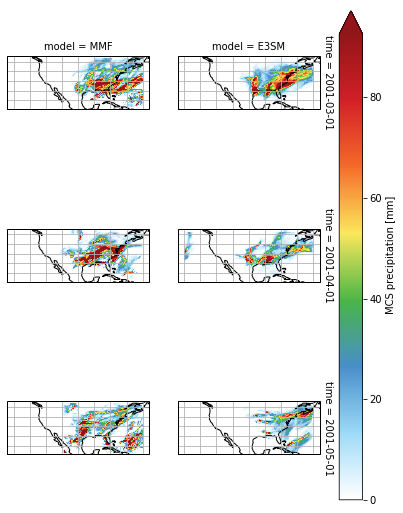

In [8]:
common_times = dsx.time.sel(time='2001')
p = dsx['mcs_precipitation'].sel(time=common_times[:3]).plot(x='lon', y='lat', row='time', col='model',
                                                   subplot_kws={'projection': ccrs.PlateCarree()}, 
                                                   transform=ccrs.PlateCarree(), cmap=cmap_prect, 
                                                   robust=True)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()

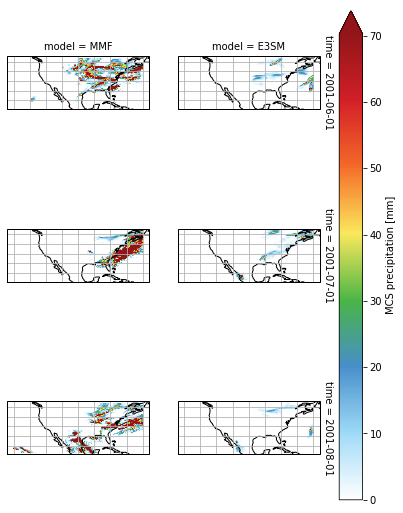

In [9]:
p = dsx['mcs_precipitation'].sel(time=common_times[3:6]).plot(x='lon', y='lat', row='time', col='model',
                                                   subplot_kws={'projection': ccrs.PlateCarree()}, 
                                                   transform=ccrs.PlateCarree(), cmap=cmap_prect, 
                                                   robust=True)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()

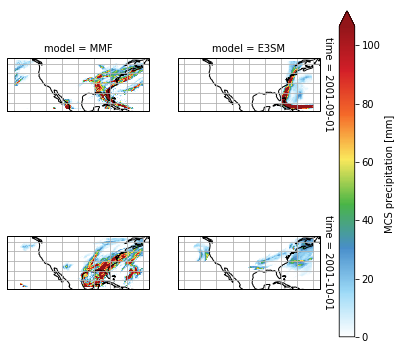

In [10]:
p = dsx['mcs_precipitation'].sel(time=common_times[6:]).plot(x='lon', y='lat', row='time', col='model',
                                                   subplot_kws={'projection': ccrs.PlateCarree()}, 
                                                   transform=ccrs.PlateCarree(), cmap=cmap_prect, 
                                                   robust=True)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


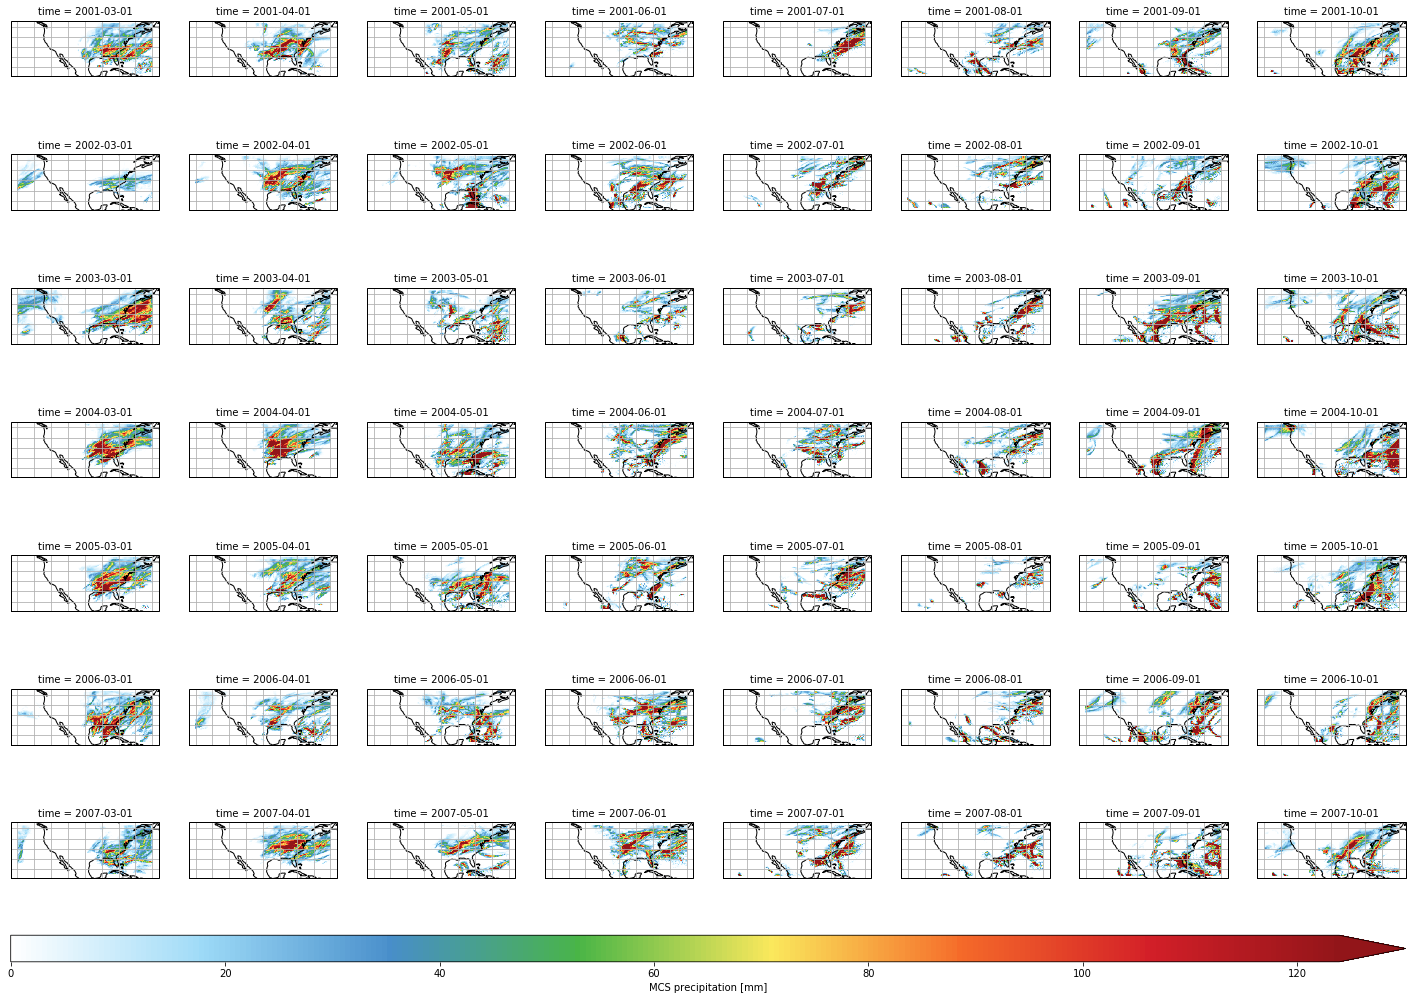

In [5]:
p = ds1['mcs_precipitation'].plot(x='lon', y='lat', col='time', col_wrap=8,
                                  subplot_kws={'projection': ccrs.PlateCarree()},
                                  transform=ccrs.PlateCarree(), cmap=cmap_prect,
                                  robust=True, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50})
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()

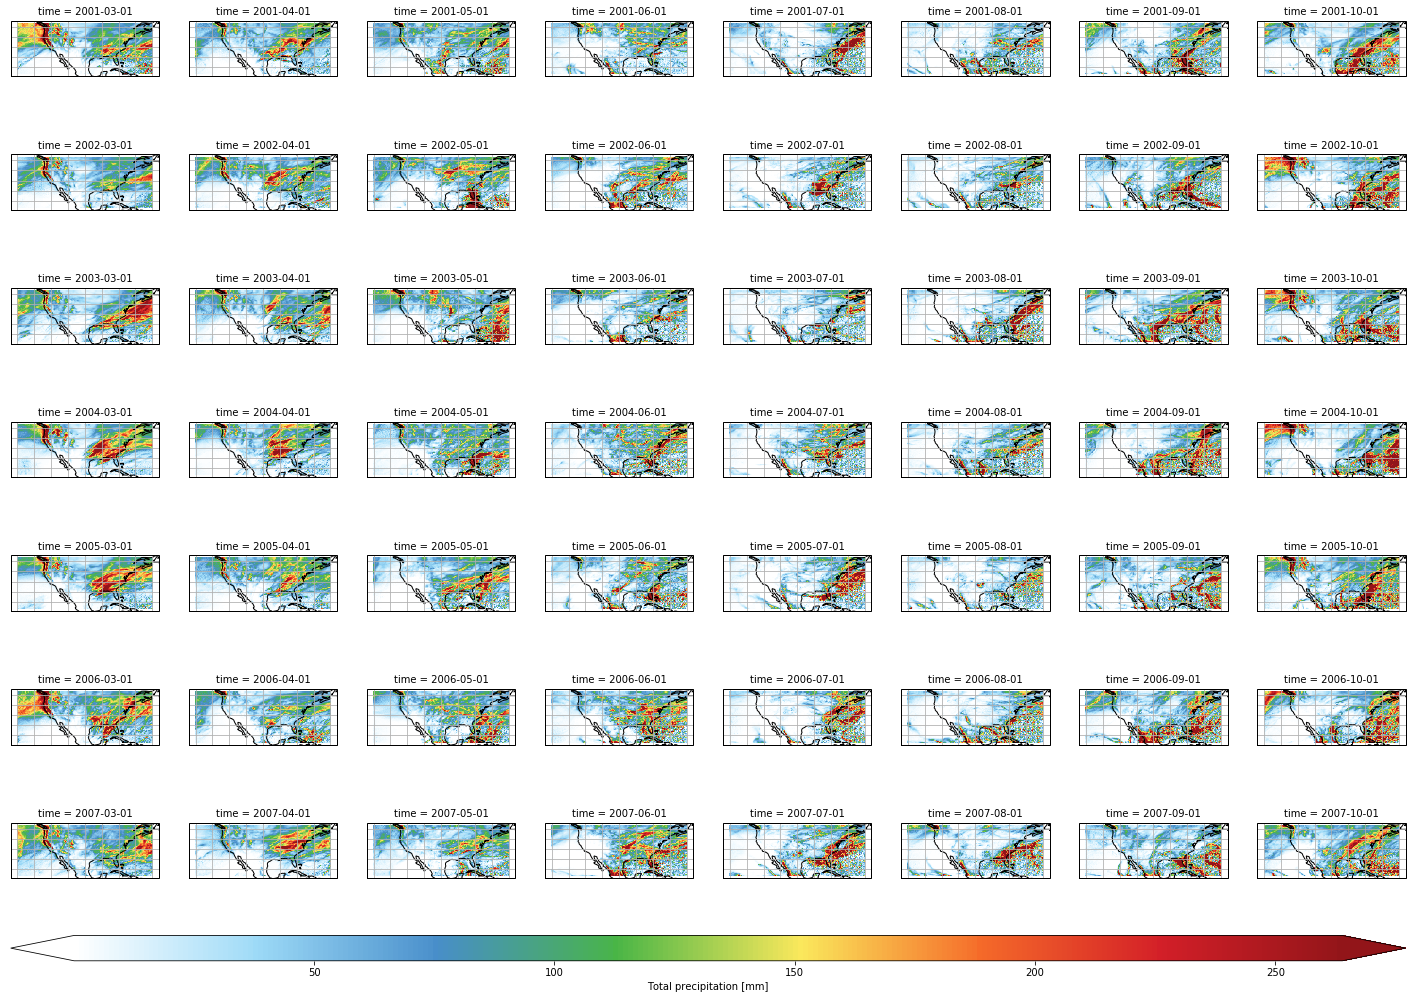

In [6]:
p = ds1['precipitation'].plot(x='lon', y='lat', col='time', col_wrap=8,
                              subplot_kws={'projection': ccrs.PlateCarree()},
                              transform=ccrs.PlateCarree(), cmap=cmap_prect,
                              robust=True, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50})
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


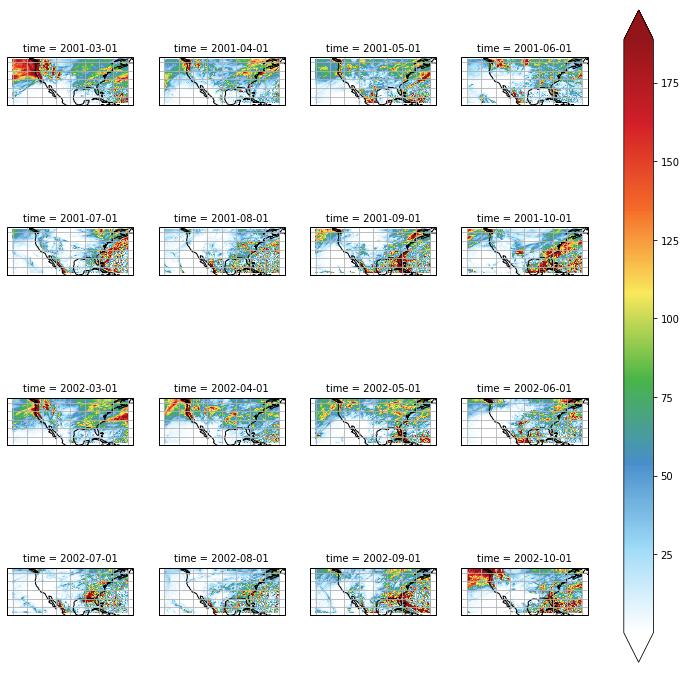

In [45]:
p = (ds1['precipitation'] - ds1['mcs_precipitation']).plot(x='lon', y='lat', col='time', col_wrap=4,
                                                           subplot_kws={'projection': ccrs.PlateCarree()},
                                                           transform=ccrs.PlateCarree(), cmap=cmap_prect,
                                                           robust=True)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()

# E3SMv1

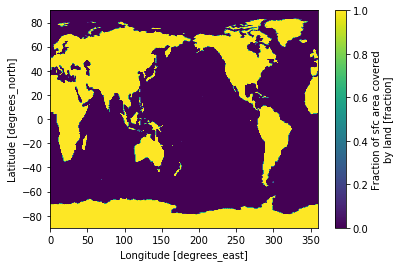

In [15]:
# Idea: Separate out which tracks start over the ocean to focus on the Orographic MCS ...
# Q1: can I use clm landmask? Actually, use LANDFRAC from h0 files.
ds_landfrac = xr.open_dataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/ne120_landfrac_720x1440.nc')
ds_landfrac['LANDFRAC'].plot()

# Plan: 
Since focus is on US MCSs here, it would be good to exclude those tracks that originate over the ocean.
- Use LANDFRAC to identify ocean (will need to find a way to exclude lakes?)
- Use detailed statistics files to drop tracks that begin over ocean. This should exclude some of the tropical cyclones that make their way up.

Before that, though, work on reproducing figures from Zhe's 2018 paper:
- Fig. 5 Central US MCS Freq / Rain Amt / Rain % (MMF vs. E3SMv1)
- Fig. 6 Hovmoller of MCS rain and MCS rain fraction
- Fig. 7 Central US diurnal cycle
- Fig. 8 Frequency distribution
And then go from there. I should maybe be able to get all these done tomorrow?

## Fig. 5

In [74]:
dsx

OrderedDict([('title', 'MCS precipitation accumulation'),
             ('contact', 'Zhe Feng, zhe.feng@pnnl.gov'),
             ('created_on', 'Fri Apr 19 08:07:41 2019')])

In [7]:
# prepare figure canvas:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

In [6]:
mjja = dsx.groupby('time.month').mean(dim='time').sel(month=slice(5, 8)).mean(dim='month')

In [7]:
# for precip total, need to sum instead of average:
mjja_count = dsx['mcs_precipitation_count'].groupby('time.month').mean(dim='time').sel(month=slice(5, 8), lat=slice(29, 50), lon=slice(255, 280)).sum(dim='month')

In [8]:
mjja_count

<xarray.DataArray 'mcs_precipitation_count' (model: 2, lat: 84, lon: 100)>
dask.array<shape=(2, 84, 100), dtype=float32, chunksize=(1, 84, 100)>
Coordinates:
  * lat      (lat) float32 29.125 29.375 29.625 29.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 255.125 255.375 255.625 ... 279.375 279.625 279.875
  * model    (model) object 'MMF' 'E3SM'

In [9]:
mjja_central = mjja.sel(lat=slice(29, 50), lon=slice(255, 278))

In [13]:
dsx.mcs_precipitation_count.attrs

OrderedDict([('long_name', 'Number of hours MCS precipitation is recorded'),
             ('units', 'hour')])

In [14]:
dsx.mcs_precipitation.attrs

OrderedDict([('long_name', 'MCS precipitation'), ('units', 'mm')])

In [10]:
def regional_mean(da, ax, lons=(256, 275), lats=(32, 48), text_loc=[257, 47], units=''):
    xy = [lons[0], lats[0]]
    width = lons[1] - lons[0]
    height = lats[1] - lats[0]
    ax.add_patch(mpatches.Rectangle(xy=xy, width=width, height=height,
                                    facecolor='none', edgecolor='magenta',
                                    alpha=1, linewidth=2,
                                    transform=ccrs.PlateCarree()))
    model = ax.get_title().split("=")[-1].strip()
    mn = da.sel(model=model).sel(lon=slice(*lons), lat=slice(*lats)).mean().values.item()
    ax.text(text_loc[0], text_loc[1], 'Mean: {:0.1f} '.format(mn) + units, color='magenta', transform=ccrs.PlateCarree())

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


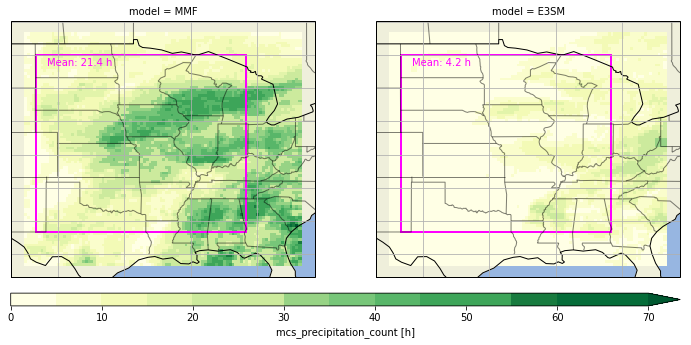

In [11]:
levels = np.arange(0, 75, 5)
mjja_count.attrs['units'] = 'h'
p = mjja_count.plot(x='lon', y='lat', col='model', figsize=(12, 6),
                    subplot_kws={'projection': ccrs.PlateCarree()}, 
                    transform=ccrs.PlateCarree(), cmap=plt.cm.YlGn,
                    levels=levels, robust=False,
                    cbar_kwargs={'orientation': 'horizontal',
                                 'pad': 0.05, 'aspect': 50,
                                 'ticks': np.arange(0, 80, 10)})
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
    ax.coastlines()
    ax.gridlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    regional_mean(mjja_count, ax, units='h')

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


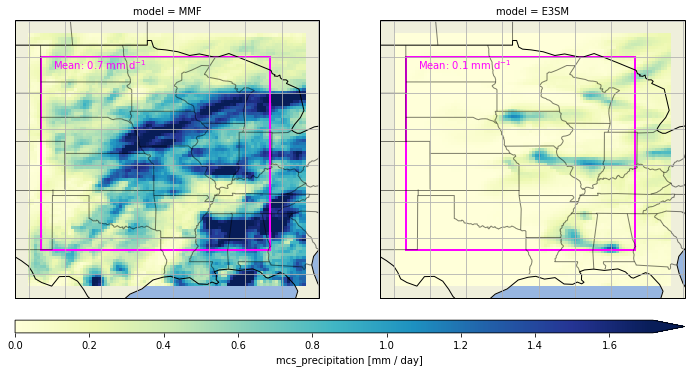

In [75]:
# total accumulated precipitation in mm. To convert, need to divide by number of samples ...
# mjja samples is mean over months ... this should be done better
fac = 4 / ndays_mmf  # x 4 months / 122 days
da = mjja_central.mcs_precipitation * fac # units = mm
da.attrs['units'] = 'mm / day'
units = 'mm d$^{-1}$'
# levels = np.arange(0, 3.5, 0.25)
p = da.plot(x='lon', y='lat', col='model', figsize=(12, 8),
            subplot_kws={'projection': ccrs.PlateCarree()}, 
            transform=ccrs.PlateCarree(), cmap=plt.cm.YlGnBu,    # cmap=cmap_prect,
            # levels=levels,
            robust=True, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50})
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
    ax.coastlines()
    ax.gridlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    regional_mean(da, ax, units=units)

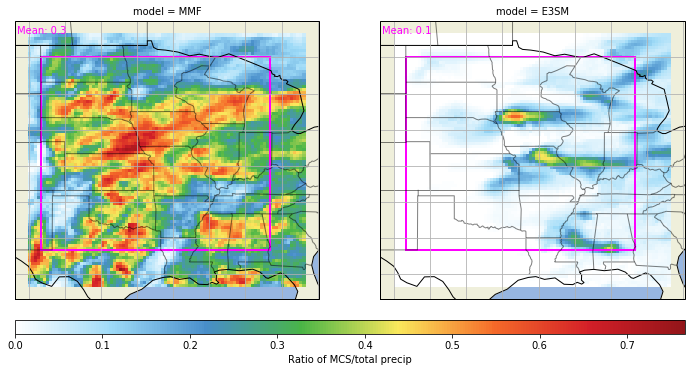

In [13]:
da = mjja_central.mcs_precipitation / mjja_central.precipitation
units = ''
# levels = np.arange(0, 0.8, 0.1)
p = da.plot(x='lon', y='lat', col='model', figsize=(12, 8),
            subplot_kws={'projection': ccrs.PlateCarree()}, 
            transform=ccrs.PlateCarree(), cmap=cmap_prect,
            robust=False, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50,
                                       'label': 'Ratio of MCS/total precip'})
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
    ax.coastlines()
    ax.gridlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    regional_mean(da, ax, units=units, text_loc=[254, 50])

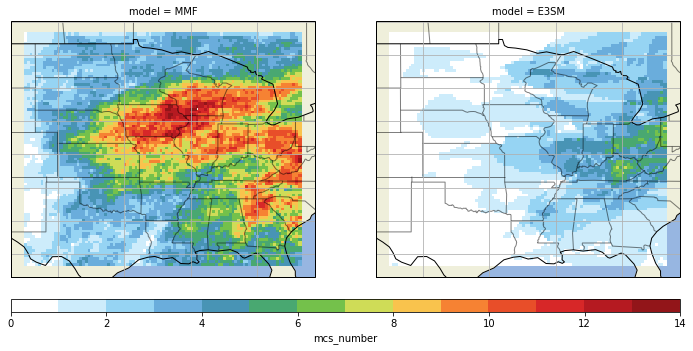

In [15]:
da = dsx['mcs_number'].groupby('time.month').mean(dim='time').sel(month=slice(5, 8), lat=slice(29, 50), lon=slice(255, 280)).sum(dim='month')

p = da.plot(x='lon', y='lat', col='model', figsize=(12, 8),
            subplot_kws={'projection': ccrs.PlateCarree()}, 
            transform=ccrs.PlateCarree(), cmap=cmap_prect,
            levels=np.arange(0, 15, 1),
            robust=False, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50})
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
    ax.coastlines()
    ax.gridlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


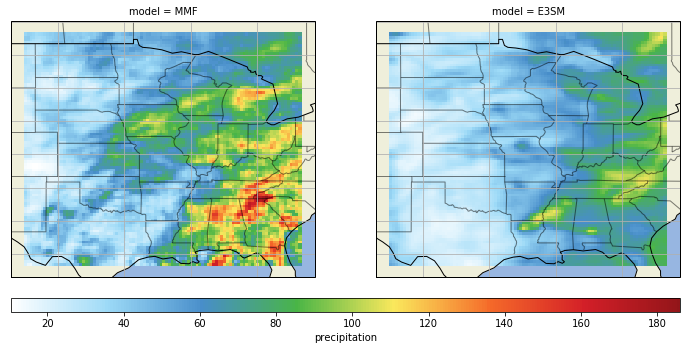

In [73]:
p = mjja_central.precipitation.plot(x='lon', y='lat', col='model', figsize=(12, 8),
                                  subplot_kws={'projection': ccrs.PlateCarree()}, 
                                  transform=ccrs.PlateCarree(), cmap=cmap_prect,
                                  robust=False, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50})
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
    ax.coastlines()
    ax.gridlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)

In [16]:
lon180 = dsx.lon.values
lon180[lon180 > 180] = lon180[lon180 > 180] - 360

In [91]:
dsx.lon.values[lon180 < -84]

array([220.125, 220.375, 220.625, 220.875, 221.125, 221.375, 221.625,
       221.875, 222.125, 222.375, 222.625, 222.875, 223.125, 223.375,
       223.625, 223.875, 224.125, 224.375, 224.625, 224.875, 225.125,
       225.375, 225.625, 225.875, 226.125, 226.375, 226.625, 226.875,
       227.125, 227.375, 227.625, 227.875, 228.125, 228.375, 228.625,
       228.875, 229.125, 229.375, 229.625, 229.875, 230.125, 230.375,
       230.625, 230.875, 231.125, 231.375, 231.625, 231.875, 232.125,
       232.375, 232.625, 232.875, 233.125, 233.375, 233.625, 233.875,
       234.125, 234.375, 234.625, 234.875, 235.125, 235.375, 235.625,
       235.875, 236.125, 236.375, 236.625, 236.875, 237.125, 237.375,
       237.625, 237.875, 238.125, 238.375, 238.625, 238.875, 239.125,
       239.375, 239.625, 239.875, 240.125, 240.375, 240.625, 240.875,
       241.125, 241.375, 241.625, 241.875, 242.125, 242.375, 242.625,
       242.875, 243.125, 243.375, 243.625, 243.875, 244.125, 244.375,
       244.625, 244.

In [17]:
ds_robust = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20010301_20011031.nc')
ds_robust

<xarray.Dataset>
Dimensions:             (nmaxmerge: 100, nmaxpf: 10, nmaxpix: 10000, times: 120, tracks: 259)
Coordinates:
  * tracks              (tracks) int32 0 1 2 3 4 5 6 ... 253 254 255 256 257 258
  * times               (times) float32 0.0 1.0 2.0 3.0 ... 117.0 118.0 119.0
Dimensions without coordinates: nmaxmerge, nmaxpf, nmaxpix
Data variables:
    length              (tracks) float32 ...
    mcs_length          (tracks) float32 ...
    mcs_type            (tracks) int16 ...
    starttrackresult    (tracks) float32 ...
    endtrackresult      (tracks) float32 ...
    base_time           (tracks, times) datetime64[ns] ...
    julian_day          (tracks, times) float64 ...
    datetimestring      (tracks, times) |S19 ...
    mcs_status          (tracks, times) float32 ...
    meanlat             (tracks, times) float32 ...
    meanlon             (tracks, times) float32 ...
    core_area           (tracks, times) float32 ...
    ccs_area            (tracks, times) float32 ...

## Figure 6
Try instead: average over latitude first, then do the groupby('time.hour') ...
Need to think of this a flux of water coming into this domain, so switch nans to zeros when doing the average

In [20]:
cluster = LocalCluster(n_workers=4)

In [45]:
# reminder: dask arrays don't support assignment, so 
#           prec_mcs.values[non_mcs] = 0 does nothing if prec_mcs is a dask array :(
def process_hovmoller(pat, region={'lat': slice(31, 48), 'lon': slice(255, 275)}):
    with Client(cluster) as client:
        ds = xr.open_mfdataset(pat, parallel=True).sel(**region)  # total 
        non_mcs = np.isnan(ds['pcptracknumber'].values)  # spots where there are no mcses
        prec_tot = ds['precipitation'].mean(dim='lat').groupby('time.hour').mean(dim='time').compute()
        prec_mcs = ds['precipitation'].copy(deep=True).load()
        prec_mcs.values[non_mcs] = 0
        prec_mcs_hrly = prec_mcs.mean(dim='lat').groupby('time.hour').mean(dim='time')
    return prec_mcs_hrly, prec_tot, ds, non_mcs

In [62]:
def plot_hovmoller(da, utc_offset=-6, cmap=plt.cm.YlGnBu, robust=True, **kwargs):
    local_time = da.hour + utc_offset
    return da.assign_coords(hour=local_time).plot(x='lon', y='hour', robust=robust, cmap=cmap, **kwargs)

In [46]:
prec_mcs_mmf, prec_tot_mmf, ds, non_mcs = process_hovmoller('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010[5-8]*.nc')

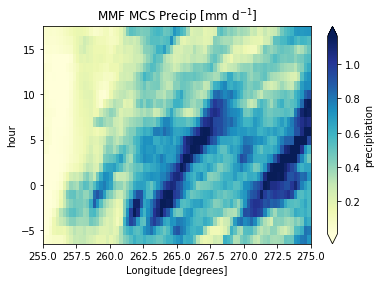

In [58]:
p = plot_hovmoller(prec_mcs_mmf * 24)
p.axes.set_title('MMF MCS Precip [mm d$^{-1}$]');

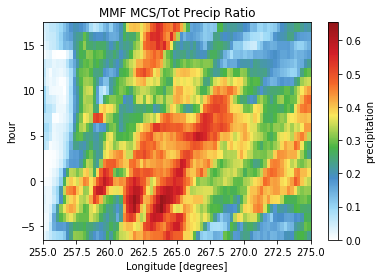

In [64]:
p = plot_hovmoller(prec_mcs_mmf / prec_tot_mmf, cmap=cmap_prect, robust=False)
p.axes.set_title('MMF MCS/Tot Precip Ratio');

In [51]:
prec_mcs_e3sm, prec_tot_e3sm, dse, non_mcs_e3sm = process_hovmoller('/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010[5-8]*.nc')

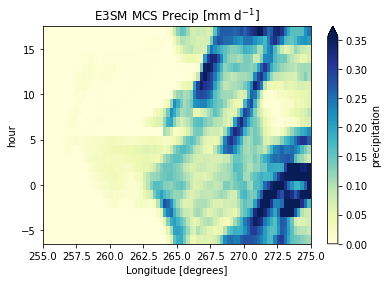

In [66]:
p1 = plot_hovmoller(prec_mcs_e3sm * 24)
p1.axes.set_title('E3SM MCS Precip [mm d$^{-1}$]');

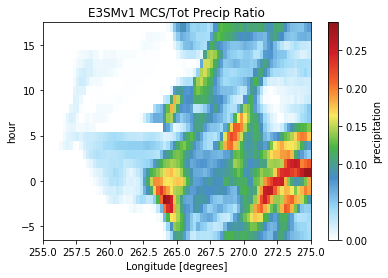

In [67]:
p2 = plot_hovmoller(prec_mcs_e3sm / prec_tot_e3sm, cmap=cmap_prect, robust=False)
p2.axes.set_title('E3SMv1 MCS/Tot Precip Ratio');

In [22]:
# something tells me I did this wrong ...
# mcs rain hovmoller
with Client(cluster) as client:
    ds_mmf = xr.open_mfdataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010[5-8]*.nc', parallel=True)
    ds_hrly = ds_mmf.groupby('time.hour').mean(dim='time')
    pcp_mask = ~np.isnan(ds_mmf['pcptracknumber'])
    mcs_prec_diurnal = ds_mmf['precipitation'].where(pcp_mask).groupby('time.hour').mean(dim='time').compute()

tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError


In [35]:
ds_e3sm = xr.open_mfdataset('/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010[5-8]*.nc', parallel=True)
dse_hrly = ds_e3sm.groupby('time.hour').mean(dim='time').compute()
pcp_mask_e3sm = ~np.isnan(ds_e3sm['pcptracknumber'])
mcs_prec_diurnal_e3sm = ds_e3sm['precipitation'].where(pcp_mask_e3sm).groupby('time.hour').mean(dim='time').compute()

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [21]:
# mcs rain hovmoller
ds_mmf = xr.open_mfdataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010[5-8]*.nc')

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [33]:
ds_mmf['precipitation']

<xarray.DataArray 'precipitation' (time: 2952, lat: 120, lon: 320)>
dask.array<shape=(2952, 120, 320), dtype=float32, chunksize=(1, 120, 320)>
Coordinates:
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * time     (time) datetime64[ns] 2001-05-01 ... 2001-08-31T23:00:00
Attributes:
    long_name:  NMQ hourly rainfall accumulation (gauge bias adjusted)
    units:      mm

In [162]:
ds_hrly = ds_mmf.groupby('time.hour').mean(dim='time')

In [216]:
mcs_prec_diurnal = ds_mmf['precipitation'].where(~np.isnan(ds_mmf['pcptracknumber'])).groupby('time.hour').mean(dim='time').compute()

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [28]:
mcs_prec = mcs_prec_diurnal.sel(lat=slice(31, 48), lon=slice(255, 275)).mean(dim='lat')

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [29]:
local_time = mcs_prec.hour - 6
# local_time[local_time <= 0] = local_time[local_time <= 0] + 24
local_time

<xarray.DataArray 'hour' (hour: 24)>
array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17])
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

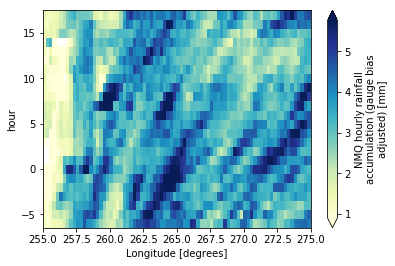

In [34]:
# Zhe was right -- this version is noisy and amped up ...
mcs_prec.attrs = ds_mmf['precipitation'].attrs
p = mcs_prec.assign_coords(hour=local_time).plot(x='lon', y='hour', robust=True, cmap=plt.cm.YlGnBu)

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


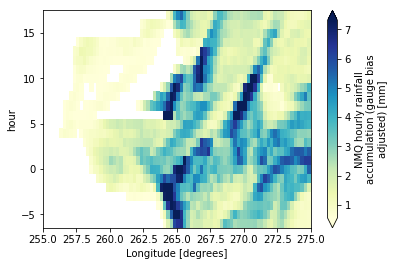

In [36]:
mcs_prec_e3sm = mcs_prec_diurnal_e3sm.sel(lat=slice(31, 48), lon=slice(255, 275)).mean(dim='lat')
mcs_prec_e3sm.attrs = ds_e3sm['precipitation'].attrs
p = mcs_prec_e3sm.assign_coords(hour=local_time).plot(x='lon', y='hour', robust=True, cmap=plt.cm.YlGnBu)

### MCS fraction Hovmollers (Fig 6 bottom row)

In [71]:
region = {'lat': slice(31, 48), 'lon': slice(255, 275)}

In [45]:
tot_mcs_prec_mmf = ds_mmf['precipitation'].where(pcp_mask).groupby('time.hour').sum(dim='time')
tot_mcs_prec_e3sm = ds_e3sm['precipitation'].where(pcp_mask_e3sm).groupby('time.hour').sum(dim='time')

tot_prec_mmf = ds_mmf['precipitation'].groupby('time.hour').sum(dim='time')
tot_prec_e3sm = ds_e3sm['precipitation'].groupby('time.hour').sum(dim='time')

mcs_prec_frac_mmf = (tot_mcs_prec_mmf.sel(**region) / tot_prec_mmf.sel(**region)).mean(dim='lat').compute()
mcs_prec_frac_e3sm = (tot_mcs_prec_e3sm.sel(**region) / tot_prec_e3sm.sel(**region)).mean(dim='lat').compute()

In [46]:
mcs_prec_frac_mmf

<xarray.DataArray 'precipitation' (hour: 24, lon: 80)>
array([[0.023839, 0.052439, 0.087413, ..., 0.199865, 0.194164, 0.176717],
       [0.015644, 0.023051, 0.06609 , ..., 0.191644, 0.229863, 0.221377],
       [0.016036, 0.022756, 0.044996, ..., 0.181993, 0.227526, 0.218892],
       ...,
       [0.016398, 0.022594, 0.0332  , ..., 0.097974, 0.104915, 0.126886],
       [0.030342, 0.035516, 0.03092 , ..., 0.137866, 0.13762 , 0.141255],
       [0.049764, 0.056152, 0.073194, ..., 0.166089, 0.161702, 0.172002]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 255.125 255.375 255.625 ... 274.375 274.625 274.875
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

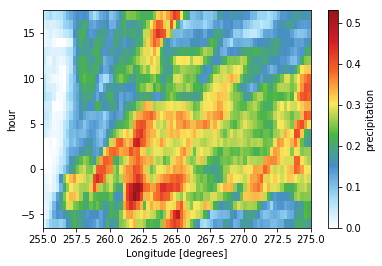

In [49]:
p = mcs_prec_frac_mmf.assign_coords(hour=local_time).plot(x='lon', y='hour', robust=False, cmap=cmap_prect)

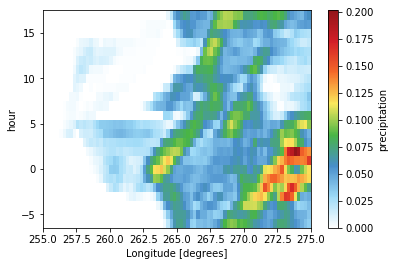

In [50]:
p = mcs_prec_frac_e3sm.assign_coords(hour=local_time).plot(x='lon', y='hour', robust=False, cmap=cmap_prect)

## Fig 7
Precipitation diurnal cycle, Lon = -103 to - 87

In [ ]:
n_norm = 122 / 24  # ndays / 24 (hr/day)

In [54]:
region = {'lat': slice(31, 48), 'lon': slice(257, 273)}
tot_mcs_prec_mmf = ds_mmf['precipitation'].where(pcp_mask).groupby('time.hour').sum(dim='time').compute()
tot_mcs_prec_e3sm = ds_e3sm['precipitation'].where(pcp_mask_e3sm).groupby('time.hour').sum(dim='time').compute()

tot_prec_mmf = ds_mmf['precipitation'].groupby('time.hour').sum(dim='time').compute()
tot_prec_e3sm = ds_e3sm['precipitation'].groupby('time.hour').sum(dim='time').compute()

In [69]:
ndays_mmf = ds_mmf['time.dayofyear'].values[-1] - ds_mmf['time.dayofyear'].values[0]
ndays_e3sm = ds_e3sm['time.dayofyear'].values[-1] - ds_e3sm['time.dayofyear'].values[0]
print(ndays_mmf, ndays_e3sm)

NameError: name 'ds_mmf' is not defined

In [72]:
prec_mcs_mmf

<xarray.DataArray 'precipitation' (hour: 24, lon: 80)>
array([[0.001249, 0.001856, 0.002587, ..., 0.032924, 0.033636, 0.029695],
       [0.00068 , 0.000818, 0.003021, ..., 0.025664, 0.034118, 0.033095],
       [0.000578, 0.00075 , 0.001993, ..., 0.019873, 0.027966, 0.025884],
       ...,
       [0.001178, 0.001396, 0.001716, ..., 0.015017, 0.017547, 0.020467],
       [0.001753, 0.001964, 0.001903, ..., 0.024446, 0.02418 , 0.022801],
       [0.002121, 0.002129, 0.002436, ..., 0.029104, 0.029471, 0.029658]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 255.125 255.375 255.625 ... 274.375 274.625 274.875
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [74]:
local_time = prec_mcs_mmf.hour - 6

Text(0, 0.5, 'precipitation [mm / d]')

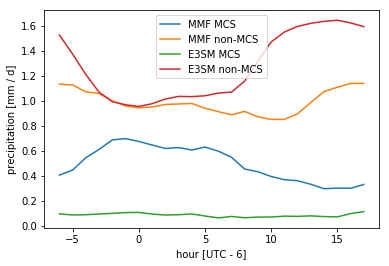

In [80]:
region = {'lon': slice(257, 273)}
mean_dims = {'dim': 'lon'}
ndays_mmf = 122
n_norm = 1 / 24
fig, ax = plt.subplots()
(prec_mcs_mmf.sel(**region).mean(**mean_dims) / n_norm).assign_coords(hour=local_time).plot(ax=ax, label='MMF MCS')
((prec_tot_mmf - prec_mcs_mmf).sel(**region).mean(**mean_dims) / n_norm).assign_coords(hour=local_time).plot(ax=ax, label='MMF non-MCS')
(prec_mcs_e3sm.sel(**region).mean(**mean_dims) / n_norm).assign_coords(hour=local_time).plot(ax=ax, label='E3SM MCS')
((prec_tot_e3sm - prec_mcs_e3sm).sel(**region).mean(**mean_dims) / n_norm).assign_coords(hour=local_time).plot(ax=ax, label='E3SM non-MCS')
ax.legend()
ax.set_xlabel('hour [UTC - 6]')
ax.set_ylabel('precipitation [mm / d]')

## Fig 8

In [72]:
regions = {'NGP': {'lat': slice(40, 48), 'lon': slice(256, 265)},
           'Mid': {'lat': slice(40, 48), 'lon': slice(265, 274)},
           'SGP': {'lat': slice(32, 40), 'lon': slice(256, 265)},
           'SE': {'lat': slice(32, 40), 'lon': slice(265, 274)}
          }